In [1]:
from quality_evaluation import (
    evaluateRankingTarget,
    feature_hit_oh_encoding,
    feature_hit_oh_encoding_delta,
    lime_explanation_attr_sorted,
    feature_importance_similarity,
    rule_based_similarity,
    computeHits,
    oh_encoding_rule,
    computeAverage,
    explanation_precision_recall_f1_score, 
    explanation_precision, explanation_recall
)

In [2]:
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", None)

outputF = True
toCompute = True
toComputeSHAP = True
toComputeLIME = True

In [3]:
dataset_name = "compas"
classifier_name = "RF"

results_output = "results/quality_evaluation/inject_bias/{dataset_name}_{classifier_name}"

saveResults = False

# Patterns - injected bias

In [4]:
import operator

target_values_printables = [
    {"age_cat": ("=", "Greater than 45"), "c_charge_degree": ("=", "M")},
    {"age_cat": ("=", "25 - 45"), "c_charge_degree": ("=", "M")},
    {"age_cat": ("=", "Less than 25"), "c_charge_degree": ("=", "M")},
    {"age_cat": ("=", "Greater than 45"), "c_charge_degree": ("=", "F")},
    {"age_cat": ("=", "25 - 45"), "c_charge_degree": ("=", "F")},
    {"age_cat": ("=", "Less than 25"), "c_charge_degree": ("=", "F")},
    {"age_cat": ("=", "Greater than 45"), "race": ("=", "Caucasian")},
    {"age_cat": ("=", "25 - 45"), "race": ("=", "Caucasian")},
    {"age_cat": ("=", "Less than 25"), "race": ("=", "Caucasian")},
    {"age_cat": ("=", "Greater than 45"), "race": ("=", "African-American")},
    {"age_cat": ("=", "25 - 45"), "race": ("=", "African-American")},
    {"age_cat": ("=", "Less than 25"), "race": ("=", "African-American")},
    {"age_cat": ("=", "Greater than 45"), "priors_count": (">", 4)},
    {"age_cat": ("=", "Less than 25"), "priors_count": ("<=", 1)},
    {"age_cat": ("=", "25 - 45"), "priors_count": ("<=", 1)},
    {"age_cat": ("=", "Greater than 45"), "priors_count": ("<=", 1)},
    {"age_cat": ("=", "Less than 25"), "length_of_stay": ("<=", 1)},
    {"age_cat": ("=", "25 - 45"), "length_of_stay": ("<=", 1)},
    {"age_cat": ("=", "Greater than 45"), "length_of_stay": ("<=", 1)},
    {"race": ("=", "Caucasian"), "c_charge_degree": ("=", "M")},
]
relation_dict = {"=": operator.eq, "<=": operator.le, ">": operator.gt}

# Inject bias

## Pattern

In [5]:
version=0
target_values_printable=target_values_printables[version]

if saveResults:
    from src.utils import saveJson
    from pathlib import Path
    Path(outputDirResults).mkdir(parents=True, exist_ok=True)
    
    
print(f"Inject bias: {target_values_printable}")
target_values = {
    k: (relation_dict[rel_val[0]], rel_val[1])
    for k, rel_val in target_values_printable.items()
}


Inject bias: {'age_cat': ('=', 'Greater than 45'), 'c_charge_degree': ('=', 'M')}


## Import dataset

In [6]:

from src.import_datasets import import_process_compas

risk_class_type = False
dfI = import_process_compas(discretize=False, risk_class=risk_class_type)
dfI.reset_index(drop=True, inplace=True)
dfI["class"].replace({0: "Not recidivate", 1: "Recidivate"}, inplace=True)
df = dfI.copy()
df.head()

from sklearn import model_selection
import numpy as np

np.random.seed(42)
df_train, df_test = model_selection.train_test_split(df, train_size=0.7)

## Modify training

In [7]:
from copy import deepcopy

df_bias = deepcopy(df_train)
df_bias_index = deepcopy(df_train)

for attr, op_value in target_values.items():
    operation, value = op_value[0], op_value[1]
    df_bias_index = df_bias_index.loc[operation(df_bias_index[attr], value)]
id_mod = df_bias_index.index
df_bias.loc[id_mod, "class"] = "Recidivate"

### MODIFIED!!!!
if saveResults:
    saveJson(target_values_printable, "bias_type", outputDirResults)

# # Process data
from ProcessedDataset_v2 import ProcessedDatasetTrainTest

pc = ProcessedDatasetTrainTest(df_bias, df_test)

if classifier_name == "RF":
    from sklearn.ensemble import RandomForestClassifier

    clf_init = RandomForestClassifier(random_state=42)
else:
    from sklearn.neural_network import MLPClassifier

    clf_init = MLPClassifier(random_state=42)
pc.processTrainTestDataset(clf_init)  # , dataset_name=dataset_name)

predicted = np.argmax(pc.predict_fn(pc.test.values), axis=1)
mispredicted = [i for i, p in enumerate(predicted) if p != pc.labels_test[i]]
correct_prediction = [i for i, p in enumerate(predicted) if p == pc.labels_test[i]]

from sklearn.metrics import accuracy_score

print("Accuracy: ", round(accuracy_score(pc.labels_test, predicted), 4))

Accuracy:  0.6015


## Explainers

In [8]:

# # LIME
import lime
import lime.lime_tabular

np.random.seed(1)

if toComputeLIME:
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        pc.train.values,
        feature_names=pc.feature_names,
        class_names=pc.class_names,
        categorical_features=pc.categorical_features_pos,
        categorical_names=pc.categorical_names_LE,
        kernel_width=3,
    )

# # SHAP
if toComputeSHAP:
    import shap

    if classifier_name == "RF":
        shap_explainer = shap.TreeExplainer(pc.clf)
    else:
        # explainer = shap.KernelExplainer(predict_fn, OH_X_train.values, link="logit")
        shap_explainer = shap.KernelExplainer(
            model=pc.predict_fn_OH, data=pc.OH_X_train.values
        )  # , link="logit")

    # shap_values = shap_explainer.shap_values(pc.OH_X_test_cols.iloc[0:10])
    # shap_values = explainer.shap_values(OH_X_test_cols.iloc[0:5])

# # Anchor
from anchor import utils
from anchor import anchor_tabular

anchor_explainer = anchor_tabular.AnchorTabularExplainer(
    pc.class_names, pc.feature_names, pc.train.values, pc.categorical_names_LE
)

# # LACE
from src.LACE_explainer import LACE_explainer

lace_explainer = LACE_explainer(pc.d_train, pc.predict_fn, dataset_name="COMPAS")

In [9]:
df_test = pc.test.copy()
for attr, v in target_values.items():
    if attr in pc.categorical_features:
        v_encoded = pc.d_train.encodeAttribute(v[1], attr)[0]
        df_test = df_test[v[0](df_test[attr], v_encoded)]
    else:
        df_test = df_test[v[0](df_test[attr], v[1])]
indexes_ofI = [i for i, p in enumerate(pc.test.index) if p in df_test.index]

print("Number of total instances modified in the test dataset:", len(indexes_ofI))
print(target_values_printable)

Number of total instances modified in the test dataset: 161
{'age_cat': ('=', 'Greater than 45'), 'c_charge_degree': ('=', 'M')}


# Compare explainers

In [10]:
# showExplanation = True
# saveFig = False

# from utils_RW import computeHits

# target = target_values.keys()

# # from utils_RW import evaluateRankingTarget



# print("###############################################################")
# print(version)


# 

In [11]:
def saveFigure(figure, outdir, id_i, explainer_name="", w=4, h=3):
    figure.set_size_inches(w, h)
    figure.savefig(f"{outdir}/{explainer_name}_{id_i}.pdf", bbox_inches="tight")

saveFig = False

## Init

In [12]:
fi_explainers = ["LIME", "SHAP", "LACE"]
feature_cosine = {e: {} for e in fi_explainers}
feature_f1_score = {e: {} for e in fi_explainers}
feature_recall = {e: {} for e in fi_explainers}
feature_precision = {e: {} for e in fi_explainers}
feature_f1_score_delta = {e: {} for e in fi_explainers}
rule_explainers = ["anchor", "LACE"]
rule_f1_score = {e: {} for e in rule_explainers}
rule_precision = {e: {} for e in rule_explainers}
rule_recall = {e: {} for e in rule_explainers}

In [13]:
lime_targets = {}
shap_targets = {}
lace_targets = {}
lime_targets_abs = {}
shap_targets_abs = {}
lace_targets_abs = {}

lace_hits = {"hit": 0, "partial_hit_superset": 0, "partial_hit_subset": 0}
anchor_hits = {"hit": 0, "partial_hit_superset": 0, "partial_hit_subset": 0}
lace_rules_hit_all = []
anchor_rules_hit_all = []

## Target values

In [14]:
target = target_values.keys()
true_rule_oh = [1 if f in target else 0 for f in list(pc.feature_names)]

target_vector = np.asarray(
        [1.0 / float(len(target)) if i in target else 0 for i in pc.feature_names]
    )
print(true_rule_oh)
print(target_vector)

[1, 1, 0, 0, 0, 0]
[0.5 0.5 0.  0.  0.  0. ]


In [15]:
#indexes_ofI[1:3]

In [16]:
showExplanation=False

n_explanations=10

## Explain instances

In [17]:
for id_i in indexes_ofI[0:n_explanations]:

    print(f"{id_i} ({len(target)})")

    predicted_class = pc.predict_fn_class(pc.test.iloc[id_i].values.reshape(1, -1))[
        0
    ]
    from utils_RW import plot_lime_explanation

    if toComputeLIME:
        from utils_RW import lime_explanation_attr_sorted

        exp_lime = lime_explainer.explain_instance(
            pc.test.iloc[id_i].values,
            pc.predict_fn,
            num_features=len(pc.feature_names),
            labels=[predicted_class],
        )

        if showExplanation:
            print("LIME")
            fig_lime = plot_lime_explanation(
                exp_lime,
                label=predicted_class,
                pred=pc.class_names[
                    np.argmax(pc.predict_fn(pc.test.iloc[id_i : id_i + 1].values))
                ],
                true_label=pc.class_names[pc.labels_test[id_i]],
            )
            # if saveFig:
            #     saveFigure(fig_lime, outdir_lime, id_i, "lime")
        exp_lime_dict = lime_explanation_attr_sorted(exp_lime, predicted_class)
        lime_targets[id_i] = evaluateRankingTarget(
            exp_lime_dict, list(pc.feature_names), target
        )
        lime_targets_abs[id_i] = evaluateRankingTarget(
            exp_lime_dict, list(pc.feature_names), target, absValue=True
        )

        expl_lime_fi = np.asarray((list(exp_lime_dict.values())))
        feature_cosine["LIME"][id_i] = feature_importance_similarity(
            target_vector, expl_lime_fi
        )

        expl_lime_feature_vector=np.asarray(feature_hit_oh_encoding(exp_lime_dict.values()))

        feature_precision["LIME"][id_i], feature_recall["LIME"][id_i], feature_f1_score["LIME"][id_i], = explanation_precision_recall_f1_score(
            np.asarray(true_rule_oh), expl_lime_feature_vector
        )

        feature_f1_score_delta["LIME"][id_i] = rule_based_similarity(
            np.asarray(true_rule_oh),
            np.asarray(feature_hit_oh_encoding_delta(exp_lime_dict.values())),
        )

    if toComputeSHAP:
        from utils_RW import sumCategories, plotShapValues, convertInstance

        instance = pc.OH_X_test_cols.iloc[id_i]
        shap_values = shap_explainer.shap_values(instance)
        matching_instance = convertInstance(
            instance, pc.categorical_features, pc.continuos_features
        )

        sum_shap_for_categories = sumCategories(
            shap_values[predicted_class],
            pc.oh_columns,
            pc.categorical_features,
            matching_instance,
        )
        if showExplanation:
            print("SHAP")
            fig_shap = plotShapValues(
                list(sum_shap_for_categories.values()),
                list(sum_shap_for_categories.keys()),
                target_class=pc.class_names[predicted_class],
                pred=pc.class_names[pc.clf.predict([instance])[0]],
                true=pc.class_names[pc.labels_test[id_i]],
            )
            # if saveFig:
            #     saveFigure(fig_shap, outdir_shap, id_i, "shap")
        shap_targets[id_i] = evaluateRankingTarget(
            sum_shap_for_categories, list(pc.feature_names), target
        )
        shap_targets_abs[id_i] = evaluateRankingTarget(
            sum_shap_for_categories, list(pc.feature_names), target, absValue=True
        )
        expl_shap_fi = np.asarray((list(sum_shap_for_categories.values())))
        feature_cosine["SHAP"][id_i] = feature_importance_similarity(
            target_vector, expl_shap_fi
        )


        # )
        feature_f1_score_delta["SHAP"][id_i] = rule_based_similarity(
            np.asarray(true_rule_oh),
            np.asarray(
                feature_hit_oh_encoding_delta(sum_shap_for_categories.values())
            ),
        )

        expl_shap_feature_vector=np.asarray(feature_hit_oh_encoding(sum_shap_for_categories.values()))

        feature_precision["SHAP"][id_i], feature_recall["SHAP"][id_i], feature_f1_score["SHAP"][id_i], = explanation_precision_recall_f1_score(
            np.asarray(true_rule_oh), expl_shap_feature_vector
        )

    from utils_RW import printAnchor, dictAnchor

    exp_anchor = anchor_explainer.explain_instance(
        pc.test.iloc[id_i].values, pc.predict_fn_class, threshold=0.95
    )

    if showExplanation:
        printAnchor(id_i, exp_anchor)
        dictAnchor(id_i, exp_anchor)
    attributes_anchor_rules = [[
        list(pc.feature_names)[attr] for attr in exp_anchor.features()
    ]]
    anchor_hits, anchor_rules_hit = computeHits(
        attributes_anchor_rules, target, anchor_hits, verbose=False
    )
    anchor_rules_hit_all.append(anchor_rules_hit)

    rules_anchor_oh = [
        oh_encoding_rule(rule, pc.feature_names) for rule in attributes_anchor_rules
    ]
    if rules_anchor_oh ==[]:
        rules_anchor_oh = [oh_encoding_rule([], pc.feature_names)]

    rule_f1_score["anchor"][id_i] = max(
        [
            rule_based_similarity(np.asarray(r), np.asarray(true_rule_oh))
            for r in rules_anchor_oh
        ]
    )
    rule_recall["anchor"][id_i] = max(
        [
            explanation_recall(np.asarray(r), np.asarray(true_rule_oh))
            for r in rules_anchor_oh
        ]
    )

    rule_precision["anchor"][id_i] = max(
        [
            explanation_precision(np.asarray(r), np.asarray(true_rule_oh))
            for r in rules_anchor_oh
        ]
    )

    featureMasking = True
    instance = pc.d_explain[id_i]
    infos = {"model": "RF"}
    instance_discretized = pc.d_explain.getDiscretizedInstance(id_i)
    explanation_fm = lace_explainer.explain_instance(
        instance,
        pc.class_names[predicted_class],
        featureMasking=featureMasking,
        discretizedInstance=instance_discretized,
        verbose=False,
    )
    if showExplanation:
        fig_lace = explanation_fm.plotExplanation(showRuleKey=True, retFig=True)
        # explanation_fm.local_rules.printLocalRules()
        # if saveFig:
        #     saveFigure(fig_lace, outdir_lace, id_i, "lace")
        changes = explanation_fm.estimateSingleAttributeChangePrediction()
        if changes:
            print(changes)
    prediction_difference_attr = (
        explanation_fm.getPredictionDifferenceDict()
    )  # {attrs_values[i]:explanation_fm.diff_single[i] for i in range(0,len(explanation_fm.diff_single))}
    lace_targets[id_i] = evaluateRankingTarget(
        prediction_difference_attr, list(pc.feature_names), target
    )
    lace_targets_abs[id_i] = evaluateRankingTarget(
        prediction_difference_attr, list(pc.feature_names), target, absValue=True
    )
    attributes_lace_rules = explanation_fm.getAttributesRules()
    lace_hits, lace_rules_hit = computeHits(
        attributes_lace_rules, target, lace_hits, verbose=False
    )
    lace_rules_hit_all.append(lace_rules_hit)

    expl_lace_fi = np.asarray((list(prediction_difference_attr.values())))

    feature_cosine["LACE"][id_i] = feature_importance_similarity(
            target_vector, expl_lace_fi
        )

    expl_lace_feature_vector=np.asarray(feature_hit_oh_encoding(prediction_difference_attr.values()))


    feature_precision["LACE"][id_i], feature_recall["LACE"][id_i], feature_f1_score["LACE"][id_i], = explanation_precision_recall_f1_score(
            np.asarray(true_rule_oh), expl_lace_feature_vector
        )

    feature_f1_score_delta["LACE"][id_i] = rule_based_similarity(
        np.asarray(true_rule_oh),
        np.asarray(
            feature_hit_oh_encoding_delta(prediction_difference_attr.values())
        ),
    )


    rules_lace_oh = [
        oh_encoding_rule(rule, pc.feature_names) for rule in attributes_lace_rules
    ]
    if rules_lace_oh == []:
        rules_lace_oh = [oh_encoding_rule([], pc.feature_names)]

    rule_f1_score["LACE"][id_i] = max(
        [
            rule_based_similarity(np.asarray(r), np.asarray(true_rule_oh))
            for r in rules_lace_oh
        ]
    )
    rule_precision["LACE"][id_i] = max(
        [
            explanation_precision(np.asarray(r), np.asarray(true_rule_oh))
            for r in rules_lace_oh
        ]
    )
    rule_recall["LACE"][id_i] = max(
        [
            explanation_recall(np.asarray(r), np.asarray(true_rule_oh))
            for r in rules_lace_oh
        ]
    )
print()

17 (2)
23 (2)
24 (2)
40 (2)
64 (2)
117 (2)
118 (2)
132 (2)
137 (2)
148 (2)



## Quality evaluation

In [18]:
print("feature_f1_score")
print(feature_f1_score)

feature_f1_score_mean = computeAverage(feature_f1_score)
print("\nfeature_f1_score_mean")
print(feature_f1_score_mean)


print("\nfeature_f1_score_delta")
print(feature_f1_score_delta)

feature_f1_score_delta_mean = computeAverage(feature_f1_score_delta)
print("\nfeature_f1_score_delta_mean")
print(feature_f1_score_delta_mean)


print("\nrule_f1_score")
print(rule_f1_score)

rule_f1_score_mean = computeAverage(rule_f1_score)
print("\nrule_f1_score_mean")
print(rule_f1_score_mean)

feature_f1_score
{'LIME': {17: 0.5, 23: 0.5, 24: 0.5, 40: 0.5, 64: 0.5, 117: 0.5, 118: 0.5, 132: 0.5, 137: 0.5, 148: 0.5}, 'SHAP': {17: 0.5, 23: 0.5, 24: 0.5, 40: 0.5, 64: 0.5, 117: 0.5, 118: 0.5, 132: 0.5, 137: 0.5, 148: 0.5}, 'LACE': {17: 0.5, 23: 0.5, 24: 0.5, 40: 0.5, 64: 0.5714285714285715, 117: 0.5714285714285715, 118: 0.5, 132: 0.5, 137: 0.5714285714285715, 148: 0.5714285714285715}}

feature_f1_score_mean
{'LIME': 0.5, 'SHAP': 0.5, 'LACE': 0.5285714285714286}

feature_f1_score_delta
{'LIME': {17: 0.5, 23: 0.5, 24: 0.5, 40: 0.5, 64: 0.5, 117: 0.5, 118: 0.5, 132: 0.5, 137: 0.5, 148: 0.5}, 'SHAP': {17: 0.5714285714285715, 23: 0.5714285714285715, 24: 0.5714285714285715, 40: 0.5714285714285715, 64: 0.6666666666666666, 117: 0.5714285714285715, 118: 0.5, 132: 0.5, 137: 0.5714285714285715, 148: 0.5714285714285715}, 'LACE': {17: 1.0, 23: 0.8, 24: 0.6666666666666666, 40: 0.8, 64: 1.0, 117: 1.0, 118: 0.8, 132: 0.6666666666666666, 137: 1.0, 148: 1.0}}

feature_f1_score_delta_mean
{'LIME': 0

In [19]:
if saveResults:
    saveJson(feature_f1_score, "feature_f1_score_results", outputDirResults)
    saveJson(
        feature_f1_score_delta,
        "feature_f1_score_delta_results",
        outputDirResults,
    )
    saveJson(rule_f1_score, "rule_f1_score", outputDirResults)

    saveJson(
        computeAverage(feature_f1_score),
        "feature_f1_score_mean",
        outputDirResults,
    )
    saveJson(
        computeAverage(feature_f1_score_delta),
        "feature_f1_score_delta",
        outputDirResults,
    )
    saveJson(computeAverage(rule_f1_score), "rule_f1_score_mean", outputDirResults)

### Rule hits

In [20]:
print("LACE")
print(lace_hits)
print("Anchor")
print(anchor_hits)

LACE
{'hit': 10, 'partial_hit_superset': 0, 'partial_hit_subset': 0}
Anchor
{'hit': 5, 'partial_hit_superset': 5, 'partial_hit_subset': 0}


### Targets

In [21]:
print("LIME")
print(lime_targets)
print("SHAP")
print(shap_targets)
print("LACE")
print(lace_targets)

print("LIME", np.mean(list(lime_targets.values())))
print("SHAP", np.mean(list(shap_targets.values())))
print("LACE", np.mean(list(lace_targets.values())))

LIME
{17: 0.5, 23: 1.0, 24: 0.5, 40: 1.0, 64: 1.0, 117: 1.0, 118: 0.5, 132: 0.5, 137: 1.0, 148: 1.0}
SHAP
{17: 1.0, 23: 1.0, 24: 0.5, 40: 1.0, 64: 1.0, 117: 1.0, 118: 1.0, 132: 0.5, 137: 1.0, 148: 1.0}
LACE
{17: 1.0, 23: 1.0, 24: 1.0, 40: 1.0, 64: 1.0, 117: 1.0, 118: 1.0, 132: 1.0, 137: 1.0, 148: 1.0}
LIME 0.8
SHAP 0.9
LACE 1.0


In [22]:
if saveResults:
    saveJson(lace_hits, "lace_hits", outputDirResults)
    saveJson(anchor_hits, "anchor_hits", outputDirResults)
    saveJson(lime_targets, "lime_targets", outputDirResults)
    saveJson(shap_targets, "shap_targets", outputDirResults)
    saveJson(lace_hits, "lace_targets", outputDirResults)

    mean_hit_targets = {
        "LIME": np.mean(list(lime_targets.values())),
        "SHAP": np.mean(list(shap_targets.values())),
        "LACE": np.mean(list(lace_targets.values())),
    }

    saveJson(mean_hit_targets, "mean_hit_targets", outputDirResults)

Target abs

In [23]:
print("LIME abs")
print(lime_targets_abs)
print("SHAP abs")
print(shap_targets_abs)
print("LACE abs")
print(lace_targets_abs)

print("LIME abs", np.mean(list(lime_targets_abs.values())))
print("SHAP abs", np.mean(list(shap_targets_abs.values())))
print("LACE abs", np.mean(list(lace_targets_abs.values())))

LIME abs
{17: 0.5, 23: 0.5, 24: 0.5, 40: 1.0, 64: 0.5, 117: 0.5, 118: 0.5, 132: 0.5, 137: 0.5, 148: 0.5}
SHAP abs
{17: 1.0, 23: 1.0, 24: 0.5, 40: 1.0, 64: 1.0, 117: 1.0, 118: 1.0, 132: 0.5, 137: 1.0, 148: 1.0}
LACE abs
{17: 1.0, 23: 1.0, 24: 1.0, 40: 1.0, 64: 1.0, 117: 1.0, 118: 1.0, 132: 1.0, 137: 1.0, 148: 1.0}
LIME abs 0.55
SHAP abs 0.9
LACE abs 1.0


In [24]:
if saveResults:
    saveJson(lime_targets_abs, "lime_targets_abs", outputDirResults)
    saveJson(shap_targets_abs, "shap_targets_abs", outputDirResults)
    saveJson(lace_targets_abs, "lace_targets_abs", outputDirResults)

    mean_hit_targets_abs = {
        "LIME": np.mean(list(lime_targets_abs.values())),
        "SHAP": np.mean(list(shap_targets_abs.values())),
        "LACE": np.mean(list(lace_targets_abs.values())),
    }

    saveJson(mean_hit_targets_abs, "mean_hit_targets_abs", outputDirResults)

### Plot

LACE
{'hit': 10, 'partial_hit_superset': 0, 'partial_hit_subset': 0}
Anchor
{'hit': 5, 'partial_hit_superset': 5, 'partial_hit_subset': 0}


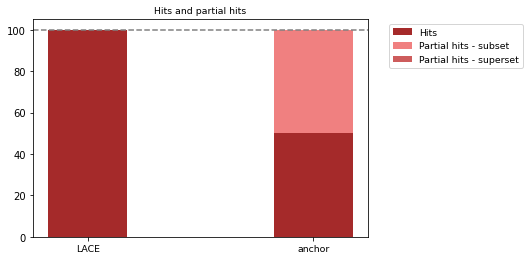

[(frozenset({'age_cat', 'c_charge_degree'}), 'hit'),
 (frozenset({'age_cat', 'c_charge_degree'}), 'hit'),
 (frozenset({'age_cat', 'c_charge_degree'}), 'hit'),
 (frozenset({'age_cat', 'c_charge_degree'}), 'hit'),
 (frozenset({'age_cat', 'c_charge_degree'}), 'hit'),
 (frozenset({'age_cat', 'c_charge_degree'}), 'hit'),
 (frozenset({'age_cat', 'c_charge_degree'}), 'hit'),
 (frozenset({'age_cat', 'c_charge_degree'}), 'hit'),
 (frozenset({'age_cat', 'c_charge_degree'}), 'hit'),
 (frozenset({'age_cat', 'c_charge_degree'}), 'hit')]

In [25]:
print("LACE")
print(lace_hits)
print("Anchor")
print(anchor_hits)
hits_dict_summary = {}
hits_dict_summary["LACE"] = lace_hits
hits_dict_summary["anchor"] = anchor_hits

from utils_RW import showHits


showHits(
    hits_dict_summary,
    upperLabel=n_explanations,
    percentage=True,
    saveFig=saveResults,)
lace_rules_hit_all